In [69]:
from numpy.random import seed
from tensorflow.random import set_seed
import random

seed(1)
set_seed(1)
random.seed(1)


import pandas as pd
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, InputLayer
from keras.callbacks import History 

import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import accuracy_score

import time

import os

import json
from datetime import datetime

from utils import k_fold, predict_and_accuracy, get_features

### Preprocessing

- Standardise numerical cols 
- Create new features


In [66]:
df = pd.read_csv('../data/Data_A.csv', header=None)

columns=['midprice_up','ss_lob_1_p','ss_lob_1_v','bs_lob_1_p','bs_lob_1_v','ss_lob_2_p','ss_lob_2_v',
'bs_lob_2_p','bs_lob_2_v','ss_lob_3_p','ss_lob_3_v','bs_lob_3_p','bs_lob_3_v','ss_lob_4_p','ss_lob_4_v',
'bs_lob_4_p','bs_lob_4_v','c1','c2','c3','c4','c5']

df.columns = columns

price_cols = ['ss_lob_1_p','bs_lob_1_p','ss_lob_2_p','bs_lob_2_p','ss_lob_3_p','bs_lob_3_p','ss_lob_4_p','bs_lob_4_p']
vol_cols = ['ss_lob_1_v','bs_lob_1_v','ss_lob_2_v','bs_lob_2_v','ss_lob_3_v','bs_lob_3_v','ss_lob_4_v','bs_lob_4_v']
prev_mid_m_cols = ['c1', 'c2', 'c3', 'c4', 'c5']


# engineer features
df, engineered_cols = get_features(df)


# do train test split
X = df.drop(columns='midprice_up')
y = df['midprice_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

means = X_train[price_cols+vol_cols+engineered_cols].mean(axis=0)
stds = X_train[price_cols+vol_cols+engineered_cols].std(axis=0)

def transform(df, means, stds):
    return (df-means)/stds

X_train[price_cols+vol_cols+engineered_cols] = transform(X_train[price_cols+vol_cols+engineered_cols], means, stds)
X_test[price_cols+vol_cols+engineered_cols] = transform(X_test[price_cols+vol_cols+engineered_cols], means, stds)



In [68]:
for epochs in [5, 10,20]:
    print(f"{epochs=}")
    
    history = History()
    model = keras.Sequential([
        InputLayer(input_shape=(len(X_train.columns))),
        Dense(units=100, activation='elu'),
        Dense(units=50, activation='elu'),
        Dense(units=20, activation='elu'),
        Dense(units=1, activation='sigmoid')
    ])
    model = keras.models.clone_model(model)
    eta = 0.003
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), loss="binary_crossentropy", metrics=["accuracy"])

    # k_fold(model, X_train, y_train, batch_size=100, epochs=epochs, history=history, splits=5)
    model.fit(X_train, y_train, batch_size=100, epochs=epochs, callbacks=[history], verbose=0)
    train_a, test_a = predict_and_accuracy(model,  X_train, X_test, y_train, y_test)
    print(f"train: {train_a:.4f}, test: {test_a:.4f}")



epochs=5
train: 0.7653, test: 0.7627
epochs=10
train: 0.7693, test: 0.7660
epochs=20
train: 0.7737, test: 0.7687


In [63]:
for units in [50, 100, 200]:
    print(f"{units=}")

    history = History()
    model = keras.Sequential([
        InputLayer(input_shape=(len(X_train.columns))),
        Dense(units=units, activation='elu'),
        Dense(units=1, activation='sigmoid')
    ])
    model = keras.models.clone_model(model)

    eta = 0.003
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), loss="binary_crossentropy", metrics=["accuracy"])

    # k_fold(model, X_train, y_train, batch_size=100, epochs=5, history=history, splits=5)
    model.fit(X_train, y_train, batch_size=100, epochs=5, callbacks=[history], verbose=0)
    train_a, test_a = predict_and_accuracy(model,  X_train, X_test, y_train, y_test)
    print(f"train: {train_a:.4f}, test: {test_a:.4f}")

units=50
train: 0.7583, test: 0.7587
units=100
train: 0.7573, test: 0.7583
units=200
train: 0.7580, test: 0.7577


In [6]:
epochs = 1

history = History()
model = keras.Sequential([
    InputLayer(input_shape=(len(X_train.columns))),
    Dense(units=100, activation='elu'),
    Dense(units=50, activation='elu'),
    Dense(units=20, activation='elu'),
    Dense(units=1, activation='sigmoid')
])
model = keras.models.clone_model(model)

eta = 0.01
model.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), loss="binary_crossentropy", metrics=["accuracy"])

# k_fold(model, X_train, y_train, batch_size=100, epochs=epochs, history=history, splits=5)
model.fit(X_train, y_train, batch_size=100, epochs=epochs, callbacks=[history], verbose=0)
predict_and_accuracy(model,  X_train, X_test, y_train, y_test)

(0.7170887449242119, 0.7096454252417556)

##### Train with only L1 order book diff feature

- Only need 1 layer of NN for this with 1 node

#### Train with important features from EDA

In [7]:
pd.set_option('display.max_rows', 500)

In [8]:

df.sort_values(by='bs_lob_1_v', ascending=False).head(100)


,midprice_up,ss_lob_1_p,ss_lob_1_v,bs_lob_1_p,bs_lob_1_v,ss_lob_2_p,ss_lob_2_v,bs_lob_2_p,bs_lob_2_v,ss_lob_3_p,...,c3,c4,c5,ss_lob_12_v,bs_lob_12_v,l1_diff,l12_diff,bs_pressure1,avg_5,momentum_up
28244,0,513800.0,100,513500.0,100200,513900.0,100,513400.0,200,514000.0,...,0,1,0,200,100400,-100100,-100200,1,0.4,0
4901,0,513800.0,150,513500.0,99645,513900.0,100,513400.0,400,514000.0,...,1,1,0,250,100045,-99495,-99795,1,0.6,1
75701,1,520400.0,1900,520000.0,58800,520500.0,100,519600.0,200,520700.0,...,1,1,0,2000,59000,-56900,-57000,1,0.6,1
2525,1,519800.0,20309,519600.0,49672,519900.0,242,519500.0,825,520000.0,...,1,0,1,20551,50497,-29363,-29946,1,0.4,0
39294,0,519800.0,8300,519600.0,49200,519900.0,139,519500.0,100,520000.0,...,0,0,1,8439,49300,-40900,-40861,1,0.6,1
95048,1,520300.0,100,520000.0,46367,520400.0,100,519900.0,300,520500.0,...,0,1,1,200,46667,-46267,-46467,1,0.4,0
86973,0,519700.0,2994,519500.0,46138,519800.0,8400,519400.0,103,519900.0,...,0,1,0,11394,46241,-43144,-34847,1,0.4,0
33127,1,519900.0,6,519800.0,40015,520000.0,647,519700.0,651,520100.0,...,0,1,0,653,40666,-40009,-40013,1,0.4,0
36348,0,520000.0,2675,519800.0,36900,520100.0,100,519700.0,200,520200.0,...,1,0,0,2775,37100,-34225,-34325,1,0.4,0
13938,1,520000.0,2575,519800.0,36900,520100.0,100,519700.0,200,520200.0,...,0,1,1,2675,37100,-34325,-34425,1,0.6,1


In [9]:
(small_mask).sum()

59673

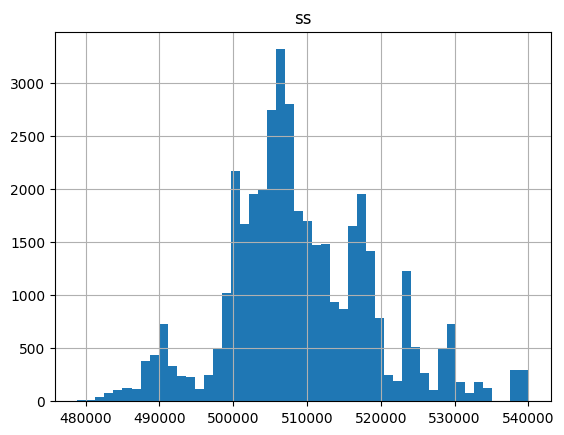

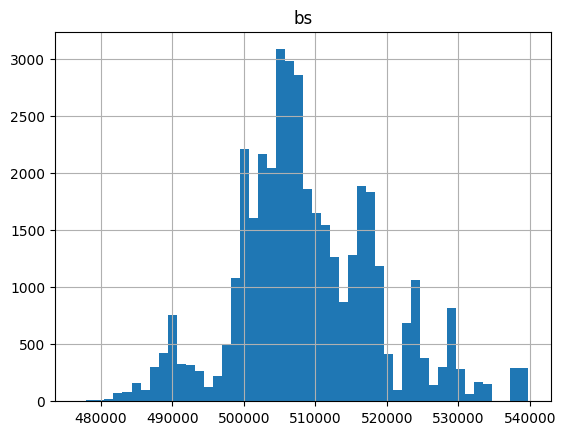

In [10]:

df['ss_lob_1_p'].hist(bins=50)
plt.title('ss');plt.show()
df['bs_lob_1_p'].hist(bins=50)
plt.title('bs'); plt.show()


### K fold cross V Strategy

#### Cross Validation and Hyp tuning
 
###### Params to tune
- learning rate
- batch size
- epochs
- Optimiser
- NN shape?
- Features?


##### CV Plan
- 5 fold CV
- look for train test stability
- return mean, median, std for all folds